## Toy examples

To illustrate the algorithms, we introduce two toy functions to minimize:

- simple quadratic problem:
$$
f(x_1, x_2) = \frac{1}{2} (x_1^2 +\gamma x_2^2)\,,
$$
where $\gamma$ determines the condition number.
- a non-quadratic function:
$$
f(x_1, x_2) = \log(e^{x_1 +3x_2-0.1}+e^{x_1 -3x_2-0.1}+e^{-x_1 -0.1})\,.
$$

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue 19 Jan 2016
Last update: Tue 14 Feb 2016

@author: Michiel Stock
michielfmstock@gmail.com

Some functions for Chapter 01: Unconstrained optimization
"""

import numpy as np
import sympy as sp
#from unconstrained import gradient_descent, newtons_method, coordinate_descent
import matplotlib.pyplot as plt
from sys import path
#path.append('../../helpers/')
#from plotting import plot_contour, add_path, blue, red, green, yellow, orange

blue = '#264653'
green = '#2a9d8f'
yellow = '#e9c46a'
orange = '#f4a261'
red = '#e76f51'
black = '#50514F'

# VISUALIZATION
# -------------


def plot_contour(f, xlim, ylim, ax, plot_f=True):
    '''
    Plots the contour of a 2D function to be minimized
    '''
    xvals = np.linspace(*xlim)
    yvals = np.linspace(*ylim)
    X, Y = np.meshgrid(xvals, yvals)
    Z = np.reshape(list(map(f, zip(X.ravel().tolist(), Y.ravel().tolist()))),
                   X.shape)
    ax.contour(X, Y, Z)
    if plot_f: ax.contourf(X, Y, Z, cmap='bone')

def add_path(ax, x_steps, col='b', label=''):
    '''
    Adds a path of an opitmization algorithm to a figure
    '''
    ax.plot([x[0] for x in x_steps], [x[1] for x in x_steps], c=col, label=label)

In [2]:
# defining the quadric function, gradient and hessian

from numpy import cos, sin

def get_transformation_matrix(gamma, theta):
    rot = np.array([[cos(theta), sin(theta)],
            [sin(theta), cos(theta)]])
    scaling = np.diag([1, gamma])
    return rot.T.dot(scaling).dot(rot)

def quadratic(x, gamma=10, theta=0.0):
    x = np.array(x).reshape((-1, 1))
    C = get_transformation_matrix(gamma, theta)
    return np.sum(0.5 * x.T.dot(C).dot(x))
    #return 0.5 * (x[0]**2 + gamma * x[1]**2)

def grad_quadratic(x, gamma=10, theta=0.0):
    x = np.array(x).reshape((-1, 1))
    C = get_transformation_matrix(gamma, theta)
    return C.dot(x)
    #return np.array([x[0], gamma * x[1]])

def hessian_quadratic(x, gamma=10, theta=0.0):
    C = get_transformation_matrix(gamma, theta)
    return C
    #return np.array([[1, 0], [0, gamma]])

In [3]:
# defining the non-quadric function, gradient and hessian


x1_, x2_ = sp.symbols('x1, x2')

nonquad_expr = sp.log(sp.exp(x1_ + 3 * x2_ - 0.1) + sp.exp(x1_ - 3 * x2_ - 0.1) +
                    sp.exp(-x1_ - 0.1))
#nonquad_expr /= 10
nonquadratic_f = sp.lambdify((x1_, x2_), nonquad_expr, np)
nonquadratic = lambda x : nonquadratic_f(x[0],x[1])
grad_nonquadratic_f = sp.lambdify((x1_, x2_), [nonquad_expr.diff(x1_),
                                  nonquad_expr.diff(x2_)], np)
grad_nonquadratic = lambda x : np.array(grad_nonquadratic_f(x[0], x[1]))

nqdx1dx1 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x1_), np)
nqdx1dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x2_), np)
nqdx2dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x2_).diff(x2_), np)

def hessian_nonquadratic(x):
    return np.array([[nqdx1dx1(x[0,:], x[1,:]), nqdx1dx2(x[0,:], x[1,:])],
                     [nqdx1dx2(x[0], x[1]), nqdx2dx2(x[0], x[1])]]).reshape(2,2)

In [4]:
# defining the non-quadric function, gradient and hessian


x1_, x2_ = sp.symbols('x1, x2')

nonquad_expr = sp.log(sp.exp(x1_ + 3 * x2_ - 0.1) + sp.exp(x1_ - 3 * x2_ - 0.1) +
                    sp.exp(-x1_ - 0.1))
#nonquad_expr /= 10
nonquadratic_f = sp.lambdify((x1_, x2_), nonquad_expr, np)
nonquadratic = lambda x : nonquadratic_f(x[0],x[1])
grad_nonquadratic_f = sp.lambdify((x1_, x2_), [nonquad_expr.diff(x1_),
                                  nonquad_expr.diff(x2_)], np)
grad_nonquadratic = lambda x : np.array(grad_nonquadratic_f(x[0], x[1]))

nqdx1dx1 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x1_), np)
nqdx1dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x2_), np)
nqdx2dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x2_).diff(x2_), np)

def hessian_nonquadratic(x):
    return np.array([[nqdx1dx1(x[0,:], x[1,:]), nqdx1dx2(x[0,:], x[1,:])],
                     [nqdx1dx2(x[0], x[1]), nqdx2dx2(x[0], x[1])]]).reshape(2,2)

In [5]:
def newtons_method(f, x0, grad_f, hess_f, alpha=0.3,
                beta=0.8, epsilon=1e-3, trace=False):
    '''
    Newton's method for minimizing functions.

    Inputs:
        - f: function to be minimized
        - x0: starting point
        - grad_f: gradient of the function to be minimized
        - hess_f: hessian matrix of the function to be minimized
        - alpha: parameter for btls
        - beta: parameter for btls
        - nu: parameter to determine if the algorithm is converged
        - trace: (bool) store the path that is followed?

    Outputs:
        - xstar: the found minimum
        - x_steps: path in the domain that is followed (if trace=True)
        - f_steps: image of x_steps (if trace=True)
    '''
    x = x0  # initial value
    if trace: x_steps = [x.copy()]
    if trace: f_steps = [f(x0)]
    while True:
        Dx = - np.linalg.solve(hess_f(x), grad_f(x))
        if - grad_f(x).T.dot(Dx) / 2 <= epsilon:   # stopping criterion
            break  # converged
        t = backtracking_line_search(f, x, Dx, grad_f, alpha, beta)
        x += Dx * t
        if trace: x_steps.append(x.copy())
        if trace: f_steps.append(f(x))
    if trace: return x, x_steps, f_steps
    else: return x


In [6]:
def backtracking_line_search(f, x0, Dx, grad_f, alpha=0.05,
                                            beta=0.6):
#     alpha=0.1,
#                                             beta=0.7):
    '''
    Uses backtracking for finding the minimum over a line.
    Inputs:
        - f: function to be searched over a line
        - x0: initial point
        - Dx: direction to search
        - grad_f: gradient of f
        - alpha
        - beta
    Output:
        - t: suggested stepsize
    '''
    t = 1  # ...
    while (f(x0+t*Dx)>f(x0)+alpha*t*np.sum(grad_f(x0) * Dx)): # ...
        t *= beta # ...
    return t

In [7]:
# defining the non-quadric function, gradient and hessian


x1_, x2_ = sp.symbols('x1, x2')

nonquad_expr = sp.log(sp.exp(x1_ + 3 * x2_ - 0.1) + sp.exp(x1_ - 3 * x2_ - 0.1) +
                    sp.exp(-x1_ - 0.1))
#nonquad_expr /= 10
nonquadratic_f = sp.lambdify((x1_, x2_), nonquad_expr, np)
nonquadratic = lambda x : nonquadratic_f(x[0],x[1])
grad_nonquadratic_f = sp.lambdify((x1_, x2_), [nonquad_expr.diff(x1_),
                                  nonquad_expr.diff(x2_)], np)
grad_nonquadratic = lambda x : np.array(grad_nonquadratic_f(x[0], x[1]))

nqdx1dx1 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x1_), np)
nqdx1dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x2_), np)
nqdx2dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x2_).diff(x2_), np)

def hessian_nonquadratic(x):
    return np.array([[nqdx1dx1(x[0,:], x[1,:]), nqdx1dx2(x[0,:], x[1,:])],
                     [nqdx1dx2(x[0], x[1]), nqdx2dx2(x[0], x[1])]]).reshape(2,2)

Number of steps quadratic function: 1
Number of steps non-quadratic function: 5


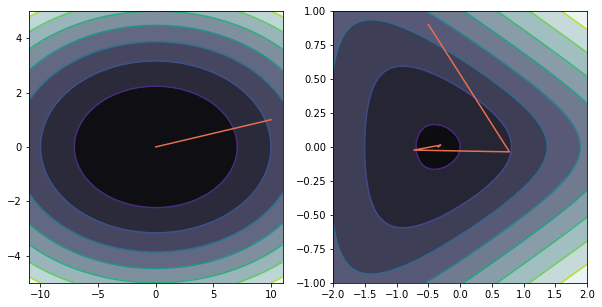

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)

xstar_q, x_steps_q, f_steps_q = newtons_method(quadratic, np.array([[10.0], [1.0]]),
                                grad_quadratic, hessian_quadratic, epsilon=1e-8, trace=True)
add_path(ax1, x_steps_q, red)

print('Number of steps quadratic function: {}'.format(len(x_steps_q) - 1))

xstar_nq, x_steps_nq, f_steps_nq = newtons_method(nonquadratic, np.array([[-0.5], [0.9]]), 
                                grad_nonquadratic, hessian_nonquadratic, epsilon=1e-8, trace=True)
add_path(ax2, x_steps_nq, red)

print('Number of steps non-quadratic function: {}'.format(len(x_steps_nq) - 1))

___
## References

Boyd, S. and Vandenberghe, L. *'Convex Optimization'*. Cambridge University Press (2004) [link](https://stanford.edu/~boyd/cvxbook/)